In [167]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
data = pd.read_csv('air_quality_weather_fires.csv')

In [169]:
data.columns

Index(['Unnamed: 0', 'date', 'site_id', 'latitude', 'longitude', 'state_name',
       'county_name', 'city_name', 'site_name', 'PM25', 'CO', 'O3', 'NO2',
       'SO2', 'AQI_PM25', 'AQI_CO', 'AQI_O3', 'AQI_NO2', 'AQI_SO2', 'AQI',
       'temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min',
       'relative_humidity_2m_mean', 'wind_speed_10m_mean',
       'wind_direction_10m_dominant', 'precipitation_sum',
       'precipitation_hours', 'et0_fao_evapotranspiration', 'weather_code',
       'distance_to_fire_km', 'fire_brightness', 'fire_frp',
       'fires_within_50km', 'fires_within_100km', 'has_nearby_fire',
       'datetime', 'month', 'day_of_week', 'is_weekend', 'season',
       'wildfire_season', 'fire_distance_category', 'fire_intensity'],
      dtype='object')

#### Use KNN to predict AQI based on wildfire-related conditions and environmental similarity.

We use the fire, weather, location and pollutant datasets to predict the AQI PM 2.5. KNN will learn similarity among days with fire.

We drop weather code and use numerical features which represent the weather since KNN works on distance calculations and one-hot encoding could add unneccessary extra features.



In [170]:
#Changing months to cyclic features to avoid breaking distance calculation of KNN
#Sine and cosine give a 2D coordinate on the circle
#Euclidean distance reflects circular closeness
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

#Changing wind direction to cyclic features
data['wind_dir_sin'] = np.sin(2 * np.pi * data['wind_direction_10m_dominant'] / 360)
data['wind_dir_cos'] = np.cos(2 * np.pi * data['wind_direction_10m_dominant'] / 360)


In [ ]:
# Target variable 
target = 'AQI_PM25'

#Predictors -> weather + fire + pollutants
# Using mean temperature and weather data
# Dropping `has_fire_nearby` since we are trying to detect wildfire impacts and it is also explained by the distance from fire columns 
predictors = [
    'latitude', 'longitude',
    'temperature_2m_mean', 'relative_humidity_2m_mean',
    'wind_speed_10m_mean', 'wind_dir_sin','wind_dir_cos',
    'precipitation_hours',
    'distance_to_fire_km', 'fire_brightness', 'fire_frp',
    'fires_within_50km', 'fires_within_100km', 'fire_intensity',
    'month_sin','month_cos', 'wildfire_season'
]


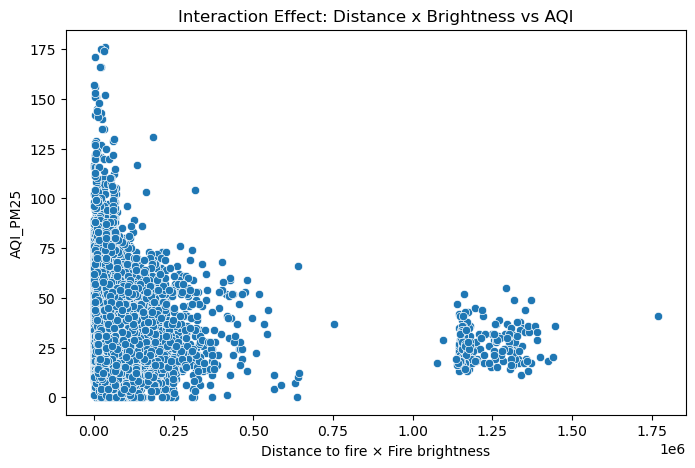

In [172]:
# Checking of interaction terms

data['dist_fire_x_brightness'] = data['distance_to_fire_km'] * data['fire_brightness']

plt.figure(figsize=(8,5))
sns.scatterplot(x='dist_fire_x_brightness', y='AQI_PM25', data=data)
plt.xlabel("Distance to fire × Fire brightness")
plt.ylabel("AQI_PM25")
plt.title("Interaction Effect: Distance x Brightness vs AQI")
plt.show()

The interaction between fire proximity and brightness captures the combined effect of nearby intense fires on air quality. While distance and brightness individually affect AQI, their product highlights cases where a close, bright fire causes disproportionately high AQI. The scatter plot shows that lower interaction values align with higher AQI spikes, suggesting that KNN can use this feature to better identify extreme pollution days.

In [173]:
predictors.append('dist_fire_x_brightness')

In [174]:
data[predictors].dtypes

latitude                     float64
longitude                    float64
temperature_2m_mean          float64
relative_humidity_2m_mean    float64
wind_speed_10m_mean          float64
wind_dir_sin                 float64
wind_dir_cos                 float64
precipitation_hours          float64
distance_to_fire_km          float64
fire_brightness              float64
fire_frp                     float64
fires_within_50km              int64
fires_within_100km             int64
fire_intensity                object
month_sin                    float64
month_cos                    float64
wildfire_season                int64
dist_fire_x_brightness       float64
dtype: object

In [175]:
#Fire intensity needs to me ordinally encoded since it is categorical
mapping = {'no_fire':0,'low': 1, 'moderate': 2, 'high': 3,'extreme':4}
data['fire_intensity_encoded'] = data['fire_intensity'].map(mapping)

In [176]:
predictors.remove('fire_intensity')
predictors.append('fire_intensity_encoded')

In [177]:
#Dropping missing values
data = data.dropna(subset=predictors + [target])

Although multicollinearity does not break KNN, because KNN doesn’t estimate weights, it just measures similarity, we will still remove columns who have multicolinarity in our predictors to increase computation speed and impprove performance slighltly by aoiding redundant calculations and avoiding one column dominating by being calculated twice.

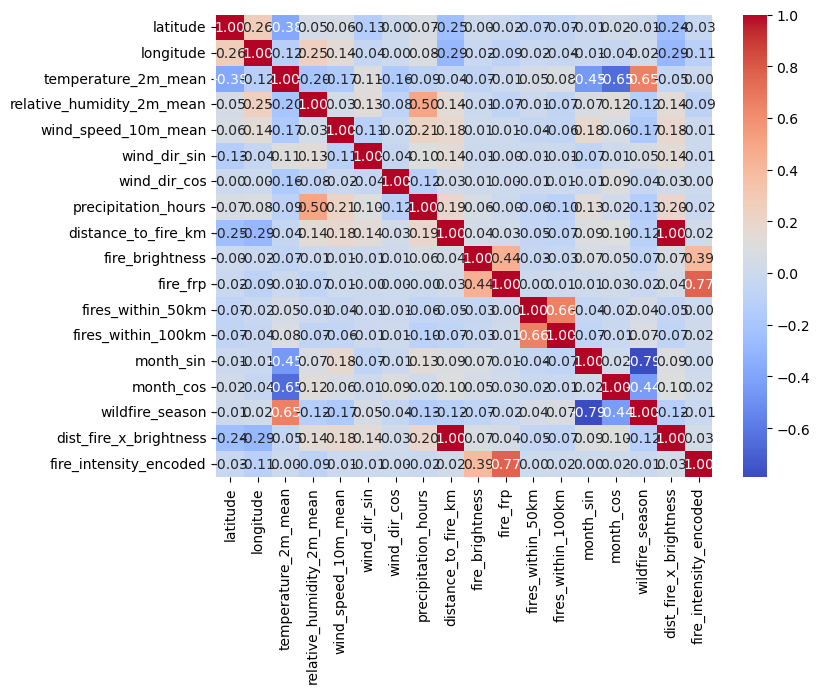

In [178]:
corr = data[predictors].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

According to the correlation map:
- Fire intensity and FRP are strongly correlated (0.77), which is expected.
- Fires within 50km and 100km are moderately correlated (0.66).
- Seasonal features (month_sin, month_cos) correlate with temperature and wildfire season, confirming the seasonal nature of fires.
- dist_fire_x_brightness and distance_to_fire_km is highly correlates since it is an interaction term

Although, fires_within_50km & fires_within_100km are correlated, they give spatial resolution. However, we can drop fire intensity column to avoid redundancy and also the dist_fire_x_brightness is almost a scaled version of distance and adds no new independent information.

In [179]:
predictors.remove('fire_intensity_encoded')
predictors.remove('dist_fire_x_brightness')

In [180]:
#Finalizing the dataset
X = data[predictors]
y = data[target]

In [181]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [182]:
# Creating the Pipeline by scaling the data and setting weights to our KNN
# Standard scaling ensures that all features contribute equally to the distance calculation
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(weights="distance"))
])

In [183]:
#Cross validation by trying different k-values across a range of odd k-values
#Odd k-values are preferred to avoid ties in the votes and choose the majority
param_grid = {'knn__n_neighbors': list(range(1, 41, 2))}
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # regression metric which determines the best k-value i.e. lowest negative mean squared error
    n_jobs=-1
)

grid.fit(X_train, y_train)


,estimator,Pipeline(step...'distance'))])
,param_grid,"{'knn__n_neighbors': [1, 3, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [184]:
#Extracting the best k-value
best_k = grid.best_params_['knn__n_neighbors']
best_score = grid.best_score_

print("Best K found via CV:", best_k)
print("Best CV Negative MSE:", best_score)


Best K found via CV: 11
Best CV Negative MSE: -194.60488243291442


Interpretation
- k= 11 gives the lowest cross-validated MSE 
  Each test point uses the 7 closest points to predict AQI_PM25
- MSE = 169.20 i.e. the absolute value. The RMSE = 13.01 which means that the model's predictions are on average about 13 AQI units off in cross-validations

In [185]:
results_df = pd.DataFrame(grid.cv_results_)
results_df["k"] = results_df["param_knn__n_neighbors"]
results_df["mean_score"] = results_df["mean_test_score"]

fig = px.line(
    results_df,
    x="k",
    y="mean_score",
    title=f"Cross-Validated Negative MSE vs. K (best k = {best_k})",
    markers=True,
    labels={"k": "Number of Neighbors (k)", "mean_score": "Mean CV Negative MSE"}
)

fig.add_scatter(
    x=[best_k],
    y=[best_score],
    mode="markers+text",
    text=[f"Best k = {best_k}"],
    textposition="top center",
    name="Best k"
)

fig.update_layout(hovermode="x unified")
fig.show()

In [186]:
# Retraining on the full training set with k = 11
knn_best = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=best_k))
])

knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("RMSE:", rmse_best)
print("R²:", r2_best)

RMSE: 13.805726976647783
R²: 0.5143541722162315


##### RMSE  
The models predictions are roughly +-13 AQI units off

##### R²  
R² = 0.47 → your model explains ~47% of the variation in AQI_PM25 based on the features used.

Remaining 53% is unexplained, probably due to other factors affecting air quality (like traffic, industrial emissions, etc.) or noise in the data.

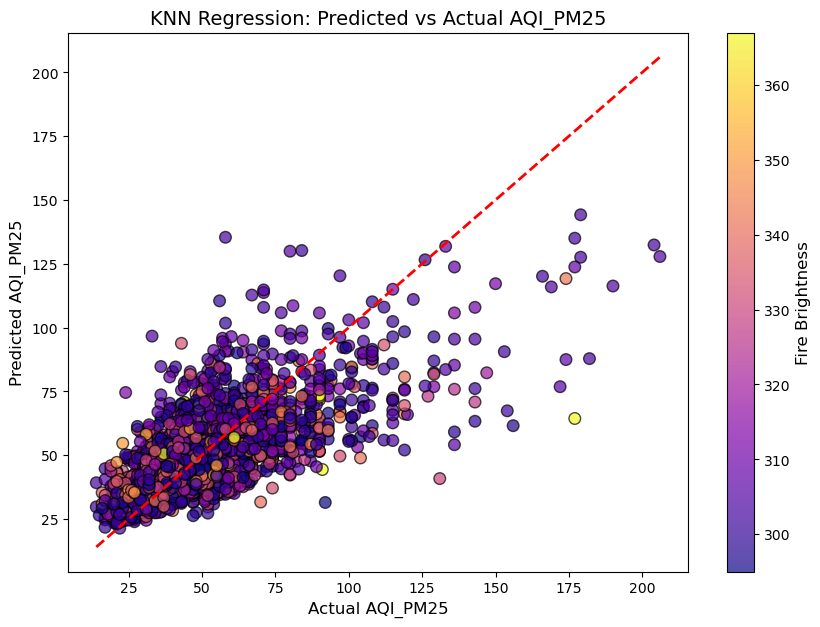

In [187]:
plt.figure(figsize=(10,7))

# Scatter plot colored by fire_brightness
scatter = plt.scatter(
    y_test, y_pred_best, 
    c=X_test['fire_brightness'],  # color by fire brightness
    cmap='plasma',  # color map
    alpha=0.7, s=70, edgecolor='k'
)

# 45-degree line for perfect prediction
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual AQI_PM25", fontsize=12)
plt.ylabel("Predicted AQI_PM25", fontsize=12)
plt.title("KNN Regression: Predicted vs Actual AQI_PM25", fontsize=14)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Fire Brightness', fontsize=12)

plt.show()



Points on the line → model predicted exactly right.

Points above the line → model overpredicted AQI.

Points below the line → model underpredicted AQI.

##### Overall Trend
The points generally follow the red dashed 45° line, which is good since it means the KNN predictions are roughly tracking the actual AQI_PM25 values.
Most points are clustered at lower AQI values (0–75), which matches the distribution in our dataset.

##### Clustering at low AQI

The dense cluster at lower AQI shows that means the model is very good at predicting typical/low AQI values, but struggles with outliers.
This is also reflected in the RMSE (~13) — it’s mostly affected by these extremes

#####  Underprediction at higher values

Notice that as AQI increases beyond ~75, the predicted values start falling below the red line. This means the model underestimates high AQI events. This is common because KNN smooths the predictions (averages neighbors), so extreme values get pulled down.


In [188]:
# Select the first test sample
X_new = X_test.iloc[[0]]  

# Predict using the trained KNN pipeline
predicted_aqi = knn_best.predict(X_new)

# Compare with actual
actual_aqi = y_test.iloc[0]

print(f"Predicted AQI_PM25: {predicted_aqi[0]}")
print(f"Actual AQI_PM25: {actual_aqi}")


Predicted AQI_PM25: 77.0909090909091
Actual AQI_PM25: 61.0
